# Data preprocess

In [1]:
import os
import random
random.seed(12)
import numpy as np
from scipy.io import savemat, loadmat

from utils import read_envi_ascii

Here, the collected data is fused and converted into the format of MATALB which is easy to read for scientific usage.

In [2]:
data_set_dir, hdr_file = "dataset", "template.hdr"
mat_file = "dataset/data.mat"
load_from_mat = True
if not load_from_mat:
    data_files = [f for f in os.listdir(data_set_dir) if f.endswith(".txt")]
    data_set = {}
    for data_file in data_files:
        data = read_envi_ascii(os.path.join(data_set_dir, data_file), hdr_file_name=os.path.join(data_set_dir, 'template.hdr'))
        data_set.update(data)
    _ = [print(k, v.shape) for k, v in data_set.items()]
    savemat(mat_file, data_set)
    print(f"Already wirte to {mat_file}!")
else:
    data = loadmat(mat_file)
    data = {k: v for k, v in data.items() if not k.startswith("__")}
    print(data.keys())
    bands = data['BANDS'].ravel()
    del data['BANDS']

dict_keys(['white_foma', 'BANDS', 'blue_plastic', 'tobacco', 'transparent_plastic', 'background', 'blue_cigarate', 'red_foma', 'yellow_paper', 'cloth', 'white_paper', 'green_plastic', 'yellow_cigarate', 'feather'])


## Draw the spectra figure before further preprocessing
In order to observe the raw data, we draw the mean spectra of the collected 12 classes of material.

In [3]:
from matplotlib.offsetbox import TextArea, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

def draw_spec(data, bands: np.ndarray):
    """
    Draw the figure of tobacco spectra

    :param data: spectra from different classes in a dict {class_name(string) : spectra_data(np.ndarray, n x bands)}
    :param bands: bands array (np.ndarray， (bands, ))
    :return:
    """
    fig, ax = plt.subplots()
    for key, value in data.items():
        if key.startswith("__"):
            continue
        print(f"{key}:  {value.shape}")
        if (key == "BANDS"):
            continue
        # draw mean spectral
        if key == "tobacco":
            mean_value = np.mean(value, axis=0)
            ax.plot(bands, mean_value, label=key, linestyle='-.')
            offsetbox = TextArea("650nm")
            point_idx = np.argmin(abs(bands-650))
            ab = AnnotationBbox(offsetbox, (bands[point_idx], mean_value[point_idx]),
                                xybox=(-20, 90),
                                xycoords='data',
                                boxcoords="offset points",
                                arrowprops=dict(arrowstyle="->"))
            ax.add_artist(ab)
            offsetbox = TextArea("670nm")
            point_idx = np.argmin(abs(bands-670))
            ab = AnnotationBbox(offsetbox, (bands[point_idx], mean_value[point_idx]),
                                xybox=(50, -20),
                                xycoords='data',
                                boxcoords="offset points",
                                arrowprops=dict(arrowstyle="->"))
            ax.add_artist(ab)
            ax.fill_between(bands, np.min(value, axis=0), np.max(value, axis=0), alpha=0.2)
        else:
            ax.plot(bands, np.mean(value, axis=0), label=key)
        ax.set_xlabel("Wavelength(nm)")
        ax.set_ylabel("Signal density")
    plt.legend()
    plt.show()

white_foma:  (594, 448)
blue_plastic:  (1150, 448)
tobacco:  (1294, 448)
transparent_plastic:  (914, 448)
background:  (1428, 448)
blue_cigarate:  (898, 448)
red_foma:  (1272, 448)
yellow_paper:  (672, 448)
cloth:  (832, 448)
white_paper:  (1203, 448)
green_plastic:  (1403, 448)
yellow_cigarate:  (968, 448)
feather:  (1613, 448)


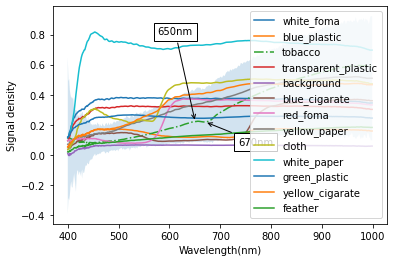

In [4]:
draw_spec(data, bands=bands)

## Black-white Calibration

From the above figure, we can find out that there are some outliers that bigger than 1 or less than 0, which can be caused by our black-white calibration formulation. The calibration formulation we adopted is show as follow:
$$S_c = \frac{S_r - D}{W - D}$$
where, the $S_c$ means the corrected spectra, the $S_r$ represents for the raw spectra captured form the hyperspectral camera, the $W$ stands for the CCD imaging result for the white calibration board and the $D$ is the CCD imaging result when the lens is covered to let the camera capture the dark noise.

The variables on the right side of our calibration formula are 12 bit depth CCD spectral imaging result, and the $S_c$ on the left side is assume to be between 0 and 1, sine normal matrial's reflection $S_r$ should be lower than $W$ but higher than $D$.

So the outliers in the above figure is supposed to be caused by the noises which make the $S_r$ higher than the $W$ or make the $W$ lower than it supposed to be. The CCD imaging result of the $W$ and $D$ can further prove this assumption.

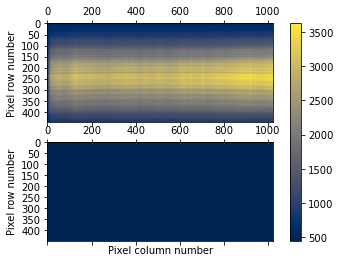

In [5]:
white, dark = "dataset/white", "dataset/black"
fig, axes = plt.subplots(nrows=2, ncols=1)
rows, cols, bands_num = 1, 1024, -1
with open(white, 'rb') as f:
    w = np.frombuffer(f.read(), dtype=np.float32).reshape((rows, bands_num, cols))[0, ...]
with open(dark, 'rb') as f:
    d = np.frombuffer(f.read(), dtype=np.float32).reshape((rows, bands_num, cols))[0, ...]
min_value, max_value = min(w.min(), d.min()), max(w.max(), d.max())
axes[0].matshow(w, vmin=min_value, vmax=max_value, cmap="cividis")
im = axes[1].matshow(d, vmin=min_value, vmax=max_value, cmap="cividis")
axes[0].set_ylabel("Pixel row number")
axes[1].set_ylabel("Pixel row number")
axes[1].set_xlabel("Pixel column number")
plt.colorbar(im, ax=axes.flat)
plt.show()

## Signal-Noise rate

The figure shows the reuslt of the CCD imaging result when the camera is exposed to the white calibration board and covered to be dark from the top to the bottom respectively. From the white imaging result, we can find out that the imaging unit on two sides of it was not activated for the reason that less light can reach these areas or our lighting system may not be able to provide enough light in these wavelength.

In order to make our data reliable, we can not allow the data captured from two sides of the CCD get thourgh. So we adpot the signal-noise ratio as a stranard to filter the meaningful data. We calculate the siganl-noise rate with the fomulation as follow:
$$r = \frac{\sum_s{\frac{w-d}{d}}}{n_s}$$
where, the $r$ means the signal-noise rate for a particular band, the $d$ is captured when the lens is covered which is supposed to be the result of merely internal noise of the camera, $s$ means the sample axis and $n_s$ means the number of imaging units to generate sample.

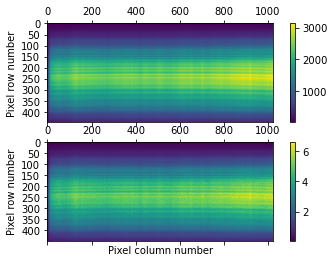

max | min | mean
dark noise 533.49 | 446.34 | 494.41
max siganl value 3133.94 | 30.51 | 1408.56
max siganl rate 6.61 | 0.06 | 2.85


In [6]:
signal = w - d
signal_rate = signal / d
fig, axs = plt.subplots(nrows=2, ncols=1)
im1 = axs[0].matshow(signal)
im2 = axs[1].matshow(signal_rate)
plt.colorbar(im1, ax=axs[0])
plt.colorbar(im2, ax=axs[1])
axs[0].set_ylabel("Pixel row number")
axs[1].set_ylabel("Pixel row number")
axs[1].set_xlabel("Pixel column number")
plt.show()
print("max | min | mean")
print(f"dark noise {d.max():.2f} | {d.min():.2f} | {d.mean():.2f}")
print(f"max siganl value {signal.max():.2f} | {signal.min():.2f} | {signal.mean():.2f}")
print(f"max siganl rate {signal_rate.max():.2f} | {signal_rate.min():.2f} | {signal_rate.mean():.2f}")

(448,)


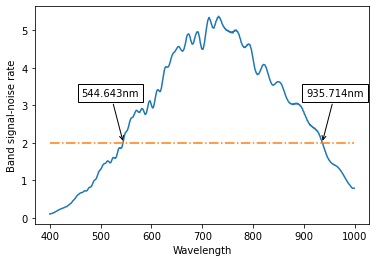

In [7]:
# we only allow the data that has a signal-noise rate bigger than 2 to get through
band_signal_threshold = 2
# find the turning point
band_signal_rate = np.mean(signal_rate, axis=1)
selected_bands = bands[band_signal_rate > band_signal_threshold]
point1, point2 = selected_bands.min(), selected_bands.max()
# draw the plot
fig, ax = plt.subplots()
print(bands.shape)
ax.plot(bands, band_signal_rate)
ax.set_xlabel("Wavelength")
ax.set_ylabel("Band signal-noise rate")
ax.plot([bands.min(), bands.max()], [band_signal_threshold, band_signal_threshold], linestyle='-.')
offsetbox = TextArea(str(point1)+"nm")
ab = AnnotationBbox(offsetbox, (point1, band_signal_threshold),
                    xybox=(-13, 50),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)
offsetbox = TextArea(str(point2)+"nm")
ab = AnnotationBbox(offsetbox, (point2, band_signal_threshold),
                    xybox=(13, 50),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

plt.show()

According to our band signal-noise rate, only the data between 544.643nm and 935.714nm will be allowed to be a part of our following modeling. The spectral after filetering by bans is look like this:

white_foma:  (594, 293)
blue_plastic:  (1150, 293)
tobacco:  (1294, 293)
transparent_plastic:  (914, 293)
background:  (1428, 293)
blue_cigarate:  (898, 293)
red_foma:  (1272, 293)
yellow_paper:  (672, 293)
cloth:  (832, 293)
white_paper:  (1203, 293)
green_plastic:  (1403, 293)
yellow_cigarate:  (968, 293)
feather:  (1613, 293)


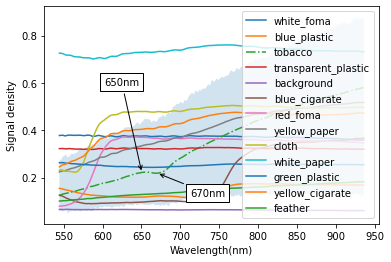

In [8]:
band_idx = band_signal_rate > band_signal_threshold
selected_data = {k: v[:, band_idx] for k, v in data.items()}
draw_spec(selected_data, bands=selected_bands)

This figure shows the result after the band selection with the signal-noise rate, from the limit value of the y axis we can find out that the outliers are eliminated which can prove our assumption for the appearance of outliers.

## Data smoothing
The SG smoothing [ref1](https://blog.finxter.com/smoothing-your-data-with-the-savitzky-golay-filter-and-python/) [ref2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) was utlized to make our spectra smooth.
Savitzky-golay smoothing filter based on Polynomials in wavelength domain.In order to find out the most suitable window size and order value, we conduct an experiment for it.
Before we do the SG smoothing, we draw some random spectra from our dataset. Since we are building a sorting system for tobacco, we mainly focus on the filtering performance of tobacco.


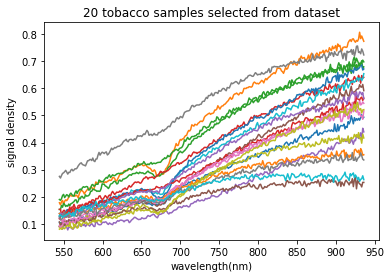

In [9]:
extract_sample_number = 20
# note that this parameter also need to be modified in draw_different_sg.py
fig, ax = plt.subplots()
random.seed(22)
select_tobacco_sample = selected_data['tobacco'][random.sample(list(range(selected_data['tobacco'].shape[0])), k=extract_sample_number), :]
ax.plot(selected_bands, select_tobacco_sample.T)
ax.set_xlabel("wavelength(nm)")
ax.set_ylabel("signal density")
ax.set_title(f"{extract_sample_number} tobacco samples selected from dataset")
plt.show()

In [10]:
from scipy.signal import savgol_filter
import pickle
# In order to explore the effect of these two parameters window_size and order of SG,
# we save the selected data to operate them in an interactive way.
# Run the draw_different_sg.py to get an interactive window.
# !python draw_different_sg.py
with open("dataset/draw_pic.p", 'wb') as f:
    pickle.dump([select_tobacco_sample, selected_bands], f)

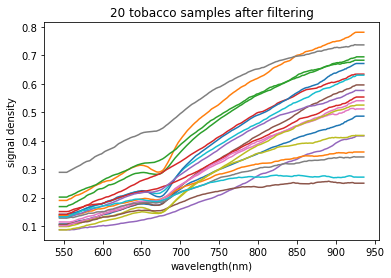

In [11]:
filtered_tobacco_sample = savgol_filter(select_tobacco_sample,
                                        window_length=15, polyorder=0)
fig, ax = plt.subplots()
p = ax.plot(selected_bands, filtered_tobacco_sample.T)
ax.set_xlabel("wavelength(nm)")
ax.set_ylabel("signal density")
ax.set_title(f"{extract_sample_number} tobacco samples after filtering")
plt.show()

In [12]:
filtered_data = {k:savgol_filter(v, window_length=15, polyorder=0) for k, v in selected_data.items()}

## Scattering Correction
Ideally, in the presence of only absorption features, the smoothed spectra should be ready for regression or classification modeling. However, due to the dominance of scattering effects, the smoothing step is usually followed by scattering correction methods, several of which are available in the chemometric literature. [ref](https://blog.csdn.net/Echo_Code/article/details/121202636?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1.pc_relevant_aa&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1.pc_relevant_aa&utm_relevant_index=2)

Spectra contain a mix of diffuse and specular reflectance.Three main factors affecting the shape of each spectrum are:

1. Different wavelengths of the incident light experience different absorption by the sample, due to the chemical nature of the sample itself. In most cases this is the signal we want to measure, and it relates to the analyte of interest.
2. Differences in particle size in the material will cause light to be deviated at different angles depending on its wavelength. Scattering effects (particle size), along with possible differences in path length constitute the major causes of variations in NIR spectra.
3. Path length differences from sample to sample due to variations in positioning and/or irregularities in the sample surface.

Scattering effects can be both additive and multiplicative. Additive effects (such as path length differences) produce a baseline displacement of the spectrum along the vertical axis, while multiplicative effects (particle size for instance)  modify the local slope of the spectrum.

### Multiplicative Scattering Correction

Now, as you can gather, getting our hands on a spectrum that is free of unwanted scattering effects is not easy, definitely not across all wavelengths we are interested in. For this reason, if the data is reasonably well behaved, we can take the average spectrum to be a close approximation to the ideal spectrum we are after. Particle size and path length effects should vary randomly from sample to sample, and therefore the average should reasonably reduce these effects, at least in the approximations that these effects are genuinely random. This is the main assumption behind MSC.
Mathematically, if we call $X_m$ the mean spectrum, the multiplicative scatter correction is done in two steps.
1. We first regress each spectrum $X_i$ against the mean spectrum $X_m$. This is done by ordinary least squares: $X_i = a_i + b_i \cdot X_m$.
2. We calculate the corrected spectrum $X_i^{MSC} = \frac{ X_i - a_i } {b_i}$

In [13]:
def multiplicative_scatter_correction(input_x, reference_spectra=None):
    # Baseline correction
    for i in range(input_x.shape[0]):
        input_x[i,:] -= input_x[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean
    reference_spectra = np.mean(input_x, axis=0) if reference_spectra is None else reference_spectra
    result = np.zeros_like(input_x)
    for idx in range(input_x.shape[0]):
        fit_res = np.polyfit(reference_spectra, input_x[idx, :], 1, full=True)
        a, b = fit_res[0][0], fit_res[0][1]
        result[idx, :] = (input_x[idx, :] - a) / b
    return result, reference_spectra

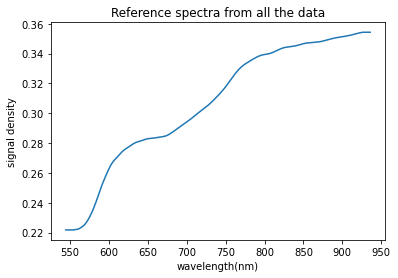

In [14]:
X = np.concatenate([v for k, v in filtered_data.items()], axis=0)
ref = np.mean(X, axis=0)
fig, ax = plt.subplots()
ax.plot(selected_bands, ref.T)
ax.set_xlabel("wavelength(nm)")
ax.set_ylabel("signal density")
ax.set_title(f"Reference spectra from all the data")
plt.show()

In [15]:
msc_tobacco_sample, _ = multiplicative_scatter_correction(filtered_tobacco_sample, reference_spectra=ref)

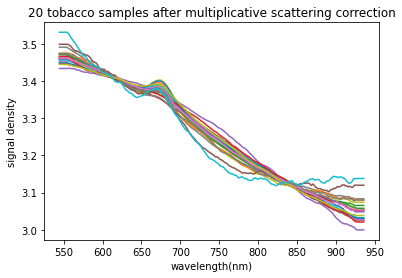

In [16]:
fig, ax = plt.subplots()
ax.plot(selected_bands, msc_tobacco_sample.T)
ax.set_xlabel("wavelength(nm)")
ax.set_ylabel("signal density")
ax.set_title(f"{extract_sample_number} tobacco samples after multiplicative scattering correction")
plt.show()

### Standard Normal Variate

Unlike MSC, SNV correction is done on each individual spectrum, and a reference spectrum is not required. The SNV correction can be divided in two conceptual steps as well.
1. Mean centre each spectrum $X_i$ by taking away its mean $\bar{X}_i$
2. Divide each mean centred spectrum by its own standard deviation: $X_i^{snv} = \frac{X_i - \bar{x}_i}{\sigma_i}$

In [17]:
def snv(input_x):
    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_x)
    for i in range(input_x.shape[0]):
        # Apply correction
        output_data[i,:] = (input_x[i,:] - np.mean(input_x[i,:])) / np.std(input_x[i,:])
    return output_data

In [18]:
snv_tobacco_sample = snv(filtered_tobacco_sample)

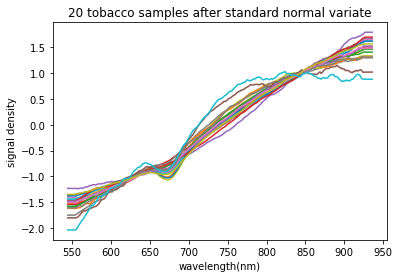

In [19]:
fig, ax = plt.subplots()
ax.plot(selected_bands, snv_tobacco_sample.T)
ax.set_xlabel("wavelength(nm)")
ax.set_ylabel("signal density")
ax.set_title(f"{extract_sample_number} tobacco samples after standard normal variate")
plt.show()

## Save all the data.

In [21]:
preprocessed_data = {k: snv(v) for k, v in filtered_data.items()}
preprocessed_data["bands"] = selected_bands
savemat(os.path.join(data_set_dir, 'preprocessed.mat'), preprocessed_data)